# 영상 형성 - 샘플링 및 양자화

PIL 및 scikit-image 라이브러리로 양자화된 샘플링 및 색상을 사용하여 영상의 크기를 조정하는 방법을 살펴본다.

# 라이브러리 임포트

In [1]:
from PIL import Image
from skimage.io import imread, imshow, show

from skimage import data, img_as_float
from skimage.color import rgb2gray
from skimage.transform import rescale

from scipy import ndimage, misc, signal, stats, fftpack as fp
import matplotlib.pylab as pylab
import numpy as np

# 샘플링

샘플링은 영상 화소의 선택/거부를 말하며 이는 공간 작업임을 의미한다. 각각 업 샘플링 및 다운 샘플링을 사용하여 영상 크기를 늘리거나 줄일 수 있다.

# 업 샘플링

영상의 크기를 늘리려면 영상을 업 샘플링해야 한다. 문제는 새로운 큰 영상은 원래의 작은 영상에서 해당 화소가 없는 일부화소를 가지므로, 이 알 수 없는 화소 값을 추측해야 한다. 그래서 다음과 같이 미지의 화소 값을 추측할 수 있다.
- 집계하는 방법 : 예를 들어, 가장 가까운 알려진 하나 이상의 화수 이웃 값의 평균값
- 보간하는 방법 : 양선형 또는 큐빅(3차) 보간으로 화소 이웃을 사용하는 보간 값

# 영상 읽기

영상 품질의 차이를 보기 위해 원본 영상을 읽는다.

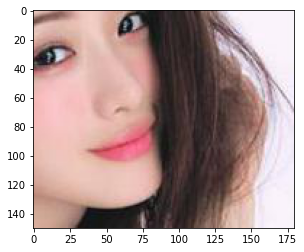

In [43]:
im = Image.open("../images/Ishihara_crop.jpg")	# 작은 시계 영상

pylab.imshow(im)
pylab.show()

# 업 샘플링

원본 영상의 너비와 높이를 5배로 늘린다.

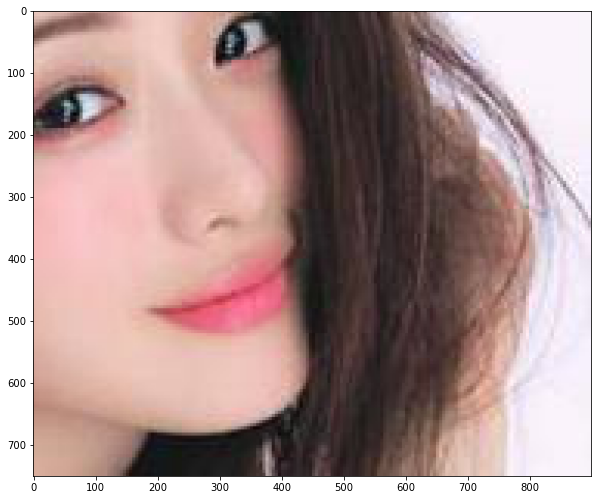

In [44]:
im1 = im.resize((im.width*5, im.height*5), Image.NEAREST)	# 최근접 이웃 보간
pylab.figure(figsize=(10,10)), pylab.imshow(im1)

pylab.show()

# 양선형 보간법

양선형 보간에 대한 PIL resize() 함수를 사용한다.
양선형 보간이 업 샘플링과 함께 사용될 때, 품질이 달라지는 것을 볼 수 있다.

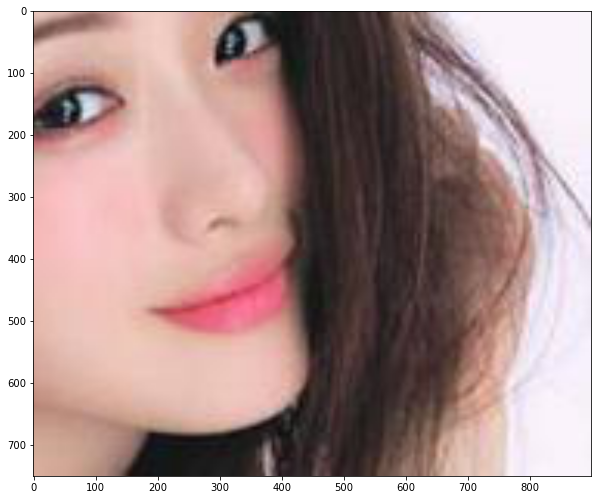

In [33]:
im1 = im.resize((im.width*5, im.height*5), Image.BILINEAR)	# 양선형 보간
pylab.figure(figsize=(10,10)), pylab.imshow(im1)
pylab.show()

# 바이큐빅 보간법

바이큐빅 보간에 대한 PIL resize() 함수를 사용한다. 품질이 달라지는 것을 볼 수 있다.

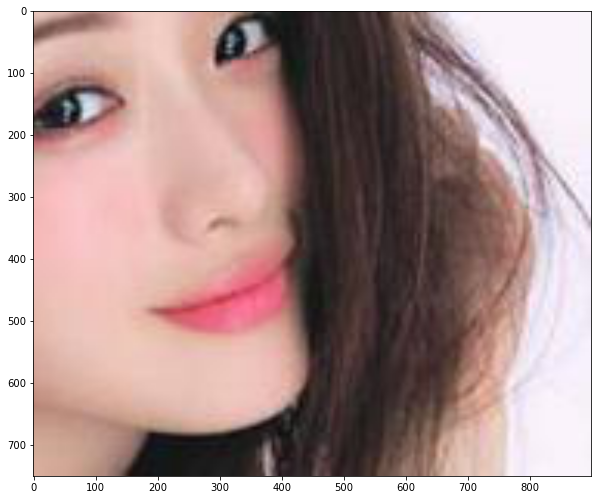

In [34]:
im.resize((im.width*10, im.height*10), Image.BICUBIC).show() # 바이큐빅 보간
pylab.figure(figsize=(10,10)), pylab.imshow(im1)
pylab.show()

# 영상 읽기

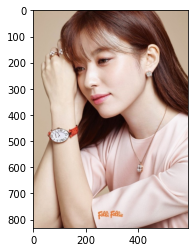

In [38]:
im = Image.open("../images/Han4.jpeg")	# 작은 시계 영상

pylab.imshow(im)
pylab.show()

# 다운 샘플링

원본 영상의 너비와 높이를 5배로 줄인다.

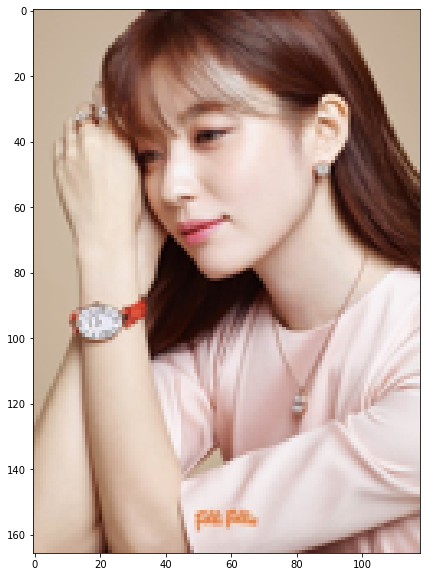

In [46]:
im = Image.open("../images/Han4.jpeg")
im.show()

im = im.resize((im.width//5, im.height//5))
pylab.figure(figsize=(15,10)), pylab.imshow(im)
pylab.show()

# 앤티-앨리어싱(Anti-aliasing)

ANTIALIAS를 사용하여 다운 샘플링의 영상품질을 올린다.

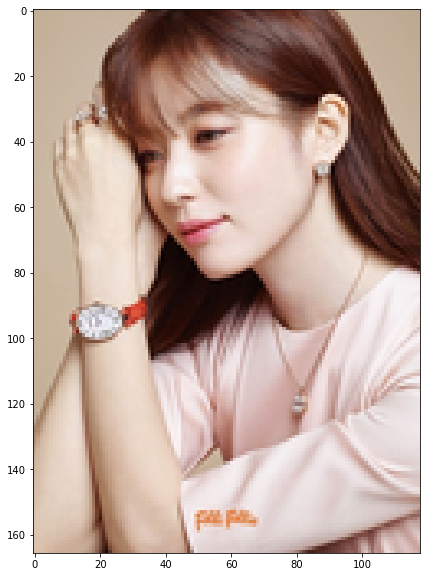

In [47]:
im = Image.open("../images/Han4.jpeg")

im = im.resize((im.width//5, im.height//5), Image.ANTIALIAS)
pylab.figure(figsize=(15,10)), pylab.imshow(im)
pylab.show()

# scikit-image resize() 함수 사용

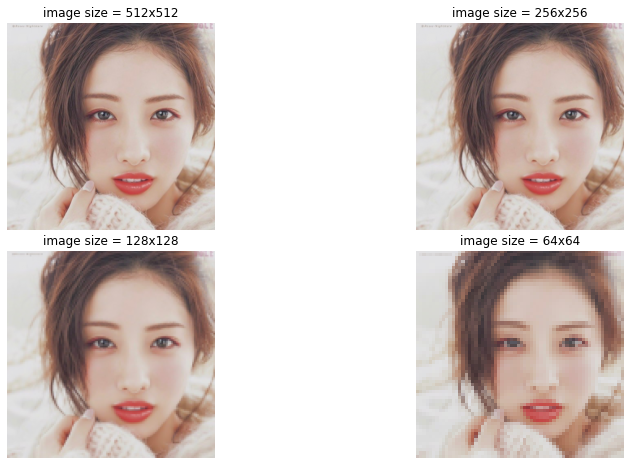

In [48]:
im = imread('../images/Ishihara3.jpeg')
im1 = im.copy()
pylab.figure(figsize=(14,8))
for i in range(4):
    pylab.subplot(2,2,i+1), pylab.imshow(im1, cmap='gray'), pylab.axis('off')
    pylab.title('image size = ' + str(im1.shape[1]) + 'x' + str(im1.shape[0]))
    im1 = rescale(im1, scale = 0.5, multichannel=True, anti_aliasing=False)
    
pylab.subplots_adjust(wspace=0.1, hspace=0.1)
pylab.show()

# 앤티-앨리어싱 코드 변경

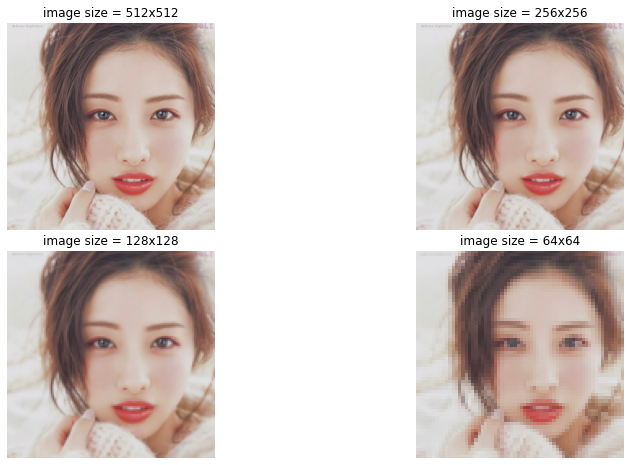

In [49]:
im = imread('../images/Ishihara3.jpeg')
im1 = im.copy()
pylab.figure(figsize=(14,8))
for i in range(4):
    pylab.subplot(2,2,i+1), pylab.imshow(im1, cmap='gray'), pylab.axis('off')
    pylab.title('image size = ' + str(im1.shape[1]) + 'x' + str(im1.shape[0]))
    im1 = rescale(im1, scale = 0.5, multichannel=True, anti_aliasing=True)
    
pylab.subplots_adjust(wspace=0.1, hspace=0.1)
pylab.show()

# 양자화

양자화는 영상의 밝기와 관련이 있으며, 화소 당 사용되는 비트 수로 정의할 수 있다. 디지털 영상은 일반적으로 256 명암도로 양자화된다. 여기서, 화소 저장을 위한 비트 수가 감소함에 따라, 양자화 에러가 증가하여 인위적인 경계 또는 윤곽 및 모자이크화가 일어나, 영상의 품질이 저하된다.

# 양자화 - PIL 사용

화소를 저장하기 위한 비트 수를 줄이면, 컬러 양자화로 인해 영상 품질이 저하되는 것을 확인할 수 있다.

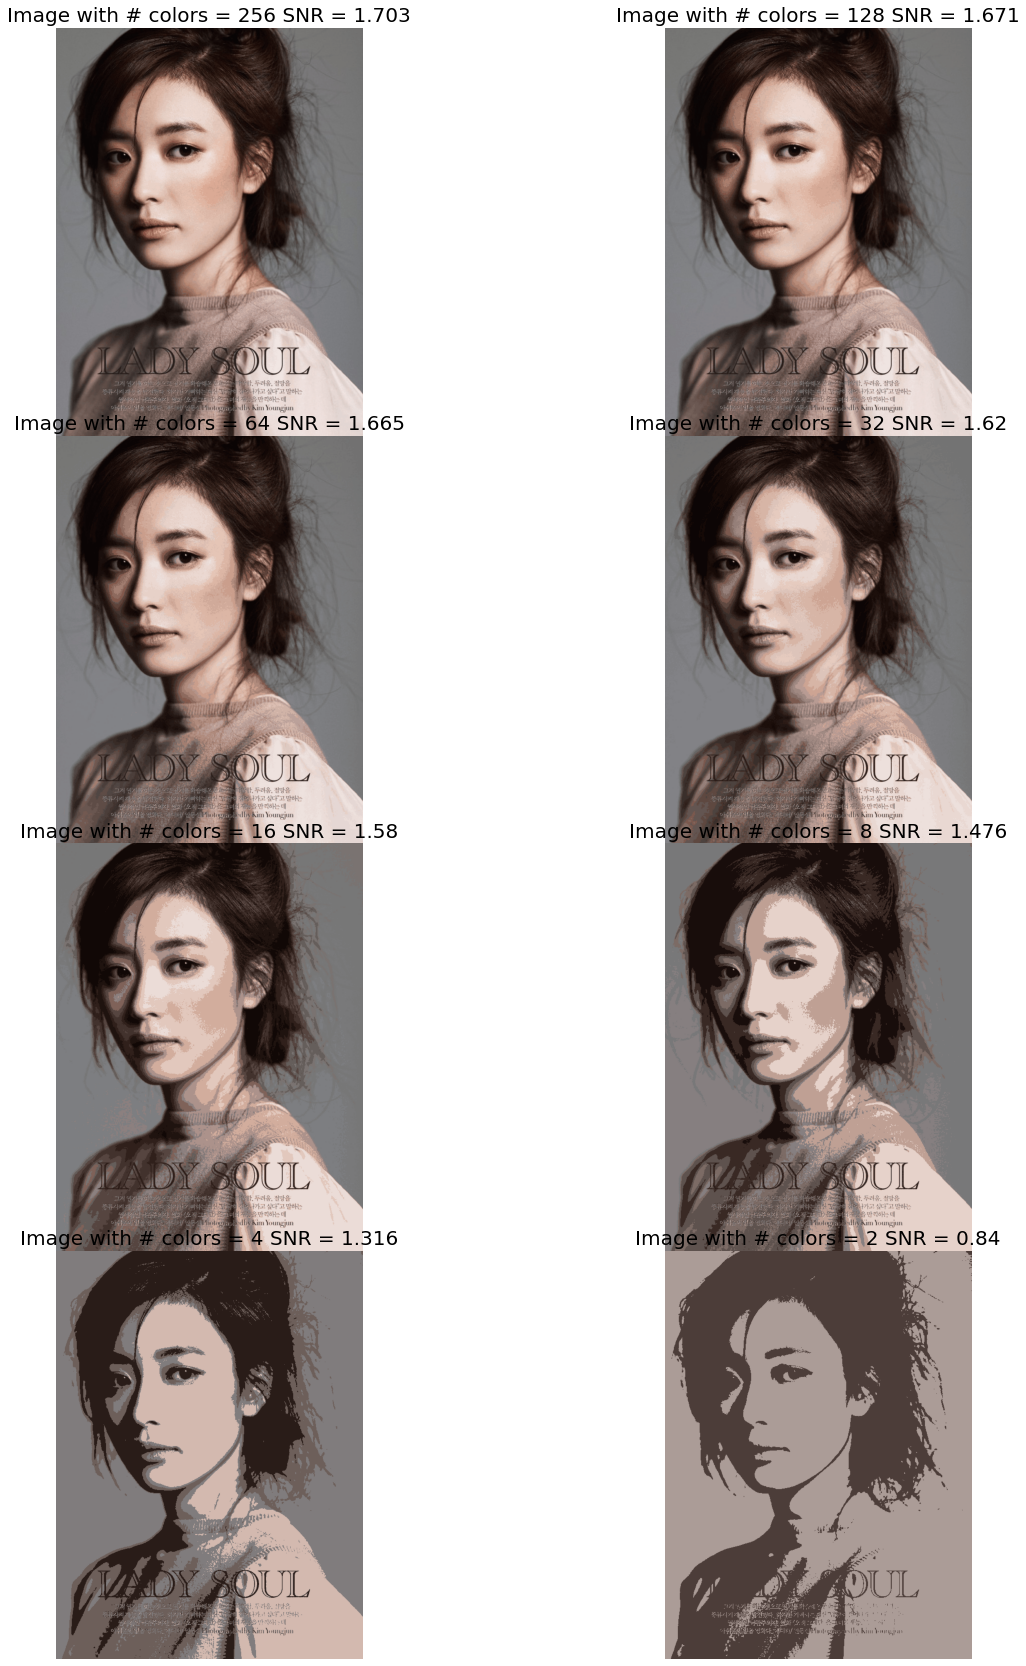

In [55]:
# scipy 1.1 버전부터 signaltonoise() 함수 제공되지 않음
# 아래 함수 구현하여 사용함
def signaltonoise(a, axis=0, ddof=0):
    a = np.asanyarray(a)
    m = a.mean(axis)
    sd = a.std(axis=axis, ddof=ddof)
    return np.where(sd == 0, 0, m/sd)

im = Image.open('../images/Han5.jpeg')
pylab.figure(figsize=(20,30))
num_colors_list = [1 << n for n in range(8,0,-1)]
snr_list = []
i = 1
for num_colors in num_colors_list:
    im1 = im.convert('P', palette=Image.ADAPTIVE, colors=num_colors)
    pylab.subplot(4,2,i), pylab.imshow(im1), pylab.axis('off')
    snr_list.append(signaltonoise(im1, axis=None))
    title = str(num_colors) + ' SNR = ' + str(np.round(snr_list[i-1],3))
    pylab.title('Image with # colors = ' + title , size=20)
    i += 1
    
pylab.subplots_adjust(wspace=0.2, hspace=0)
pylab.show()

# 컬러 양자화의 영향

영상의 SNR에 컬러 양자화의 영향을 그래프로 표현한다. SNR은 일반적으로 영상 품질의 척도이다. SNR이 높을수록 품질이 좋다.

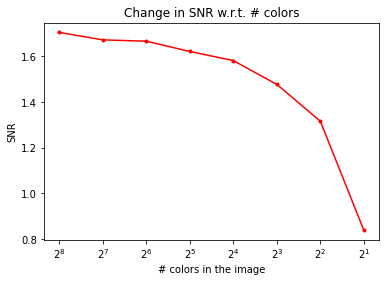

In [56]:
pylab.plot(num_colors_list, snr_list, 'r.-')
pylab.xlabel('# colors in the image')
pylab.ylabel('SNR')
pylab.title('Change in SNR w.r.t. # colors')
pylab.xscale('log', basex=2)
pylab.gca().invert_xaxis()
pylab.show()